In [26]:
import json
import requests
import librosa
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('light.mplstyle')

In [27]:
def fetch_yahoo_finance_ticker(ticker, save_json=False):
    headers = {
        'accept': '*/*',
        'accept-language': 'en-US,en;q=0.9,sv-SE;q=0.8,sv;q=0.7,ru;q=0.6',
        'dnt': '1',
        'origin': 'https://finance.yahoo.com',
        'priority': 'u=1, i',
        'referer': f'https://finance.yahoo.com/quote/{ticker}/',
        'sec-ch-ua': '"Not)A;Brand";v="99", "Google Chrome";v="127", "Chromium";v="127"',
        'sec-ch-ua-mobile': '?0',
        'sec-ch-ua-platform': '"Linux"',
        'sec-fetch-dest': 'empty',
        'sec-fetch-mode': 'cors',
        'sec-fetch-site': 'same-site',
        'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0.0 Safari/537.36'
    }
    url = f"""https://query2.finance.yahoo.com/v8/finance/chart/{ticker}?period1=1690318800&period2=1723959110&interval=1d&includePrePost=true&events=div%7Csplit%7Cearn&&lang=en-US&region=US"""
    response = requests.request("GET", url, headers=headers, data={})
    if response.status_code == 200:
        data = response.json()
        timestamps = data['chart']['result'][0]['timestamp']
        prices = data['chart']['result'][0]['indicators']['quote'][0]['close']
        df = pd.DataFrame({'timestamp': timestamps, 'price': prices})
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
        if save_json:
            with open('S&P500.json', 'w') as outfile:
                json.dump(data, outfile)
        return df
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")
        return None

df = fetch_yahoo_finance_ticker(ticker="%5EGSPC")
df.sample(10)

,timestamp,price
221,2024-06-10 13:30:00,5360.790039
153,2024-03-04 14:30:00,5130.950195
24,2023-08-28 13:30:00,4433.310059
87,2023-11-27 14:30:00,4550.430176
107,2023-12-26 14:30:00,4774.750000
116,2024-01-09 14:30:00,4756.500000
266,2024-08-14 13:30:00,5455.209961
125,2024-01-23 14:30:00,4864.600098
228,2024-06-20 13:30:00,5473.169922
177,2024-04-08 13:30:00,5202.390137


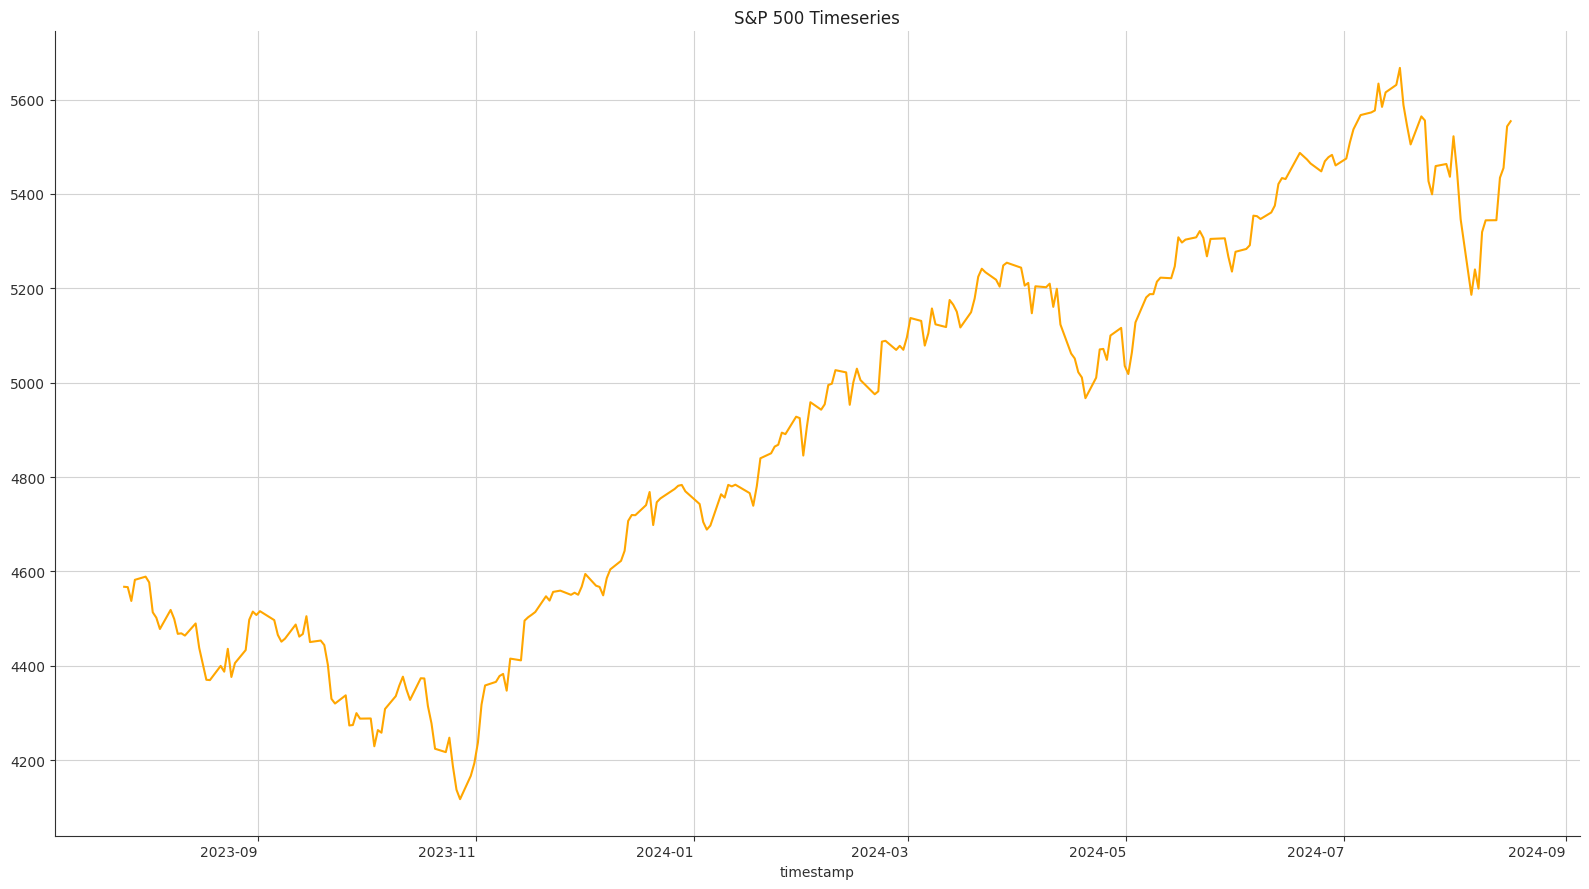

In [28]:
def plot_timeseries(df):
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    df.plot(x='timestamp', y='price', ax=ax)
    plt.title('S&P 500 Timeseries')
    plt.xticks(rotation=0)
    plt.legend().set_visible(False)
    plt.tight_layout()
    plt.savefig('outputs/images/s&p500_timeseries.png')
    plt.show()

plot_timeseries(df)

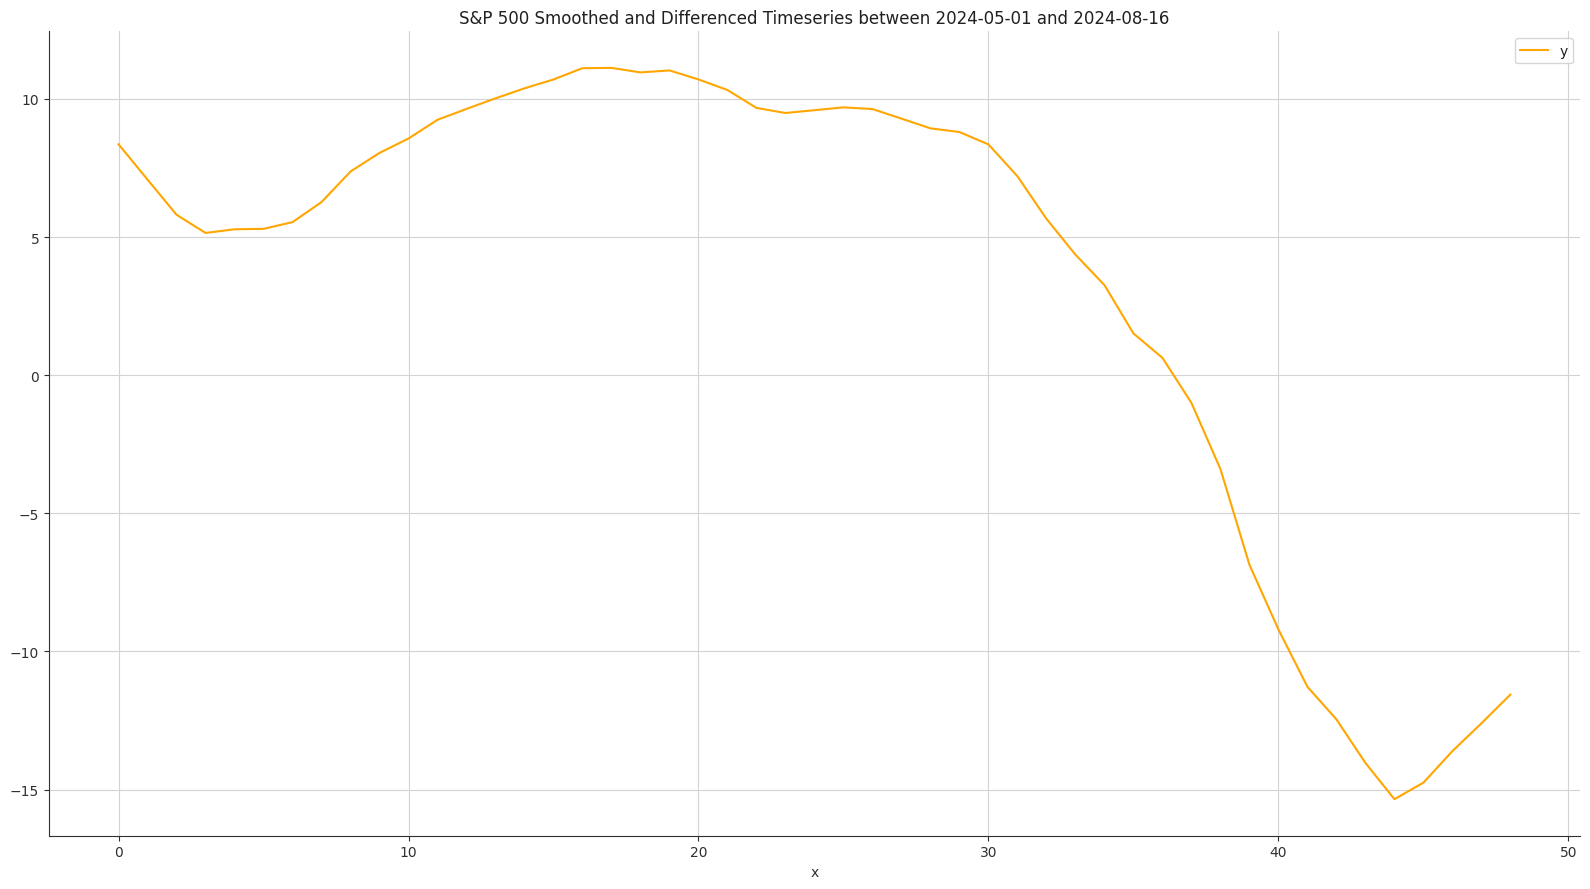

In [29]:
def process_and_smooth_data(inout_df, cut_off_date='2024-05-01'):
    df = inout_df.copy(deep=True)
    df = df[df['timestamp'] >= cut_off_date]
    # 14 day rolling average
    df['y'] = df['price'].astype(int).rolling(window=14).mean()
    df.dropna(inplace=True)
    # Move the time series to have a mean of 0
    df['y'] = df['y'] - df['y'].mean()
    # Differencing the time series and smoothing it
    df['y'] = df['y'].diff().bfill().rolling(window=14).mean()
    df.dropna(inplace=True)
    # set x equal to index instead of timeseries x
    df['x'] = df.reset_index().index
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    df.plot(x='x', y='y', ax=ax)
    plt.title(f'S&P 500 Smoothed and Differenced Timeseries between {cut_off_date} and {df["timestamp"].max().strftime("%Y-%m-%d")}')
    plt.tight_layout()
    plt.savefig('outputs/images/s&p500_transformed.png')
    plt.show()
    return df

df = process_and_smooth_data(df)
df[['x', 'y']].to_csv('inputs/sp500_array.csv', index=False, header=False)

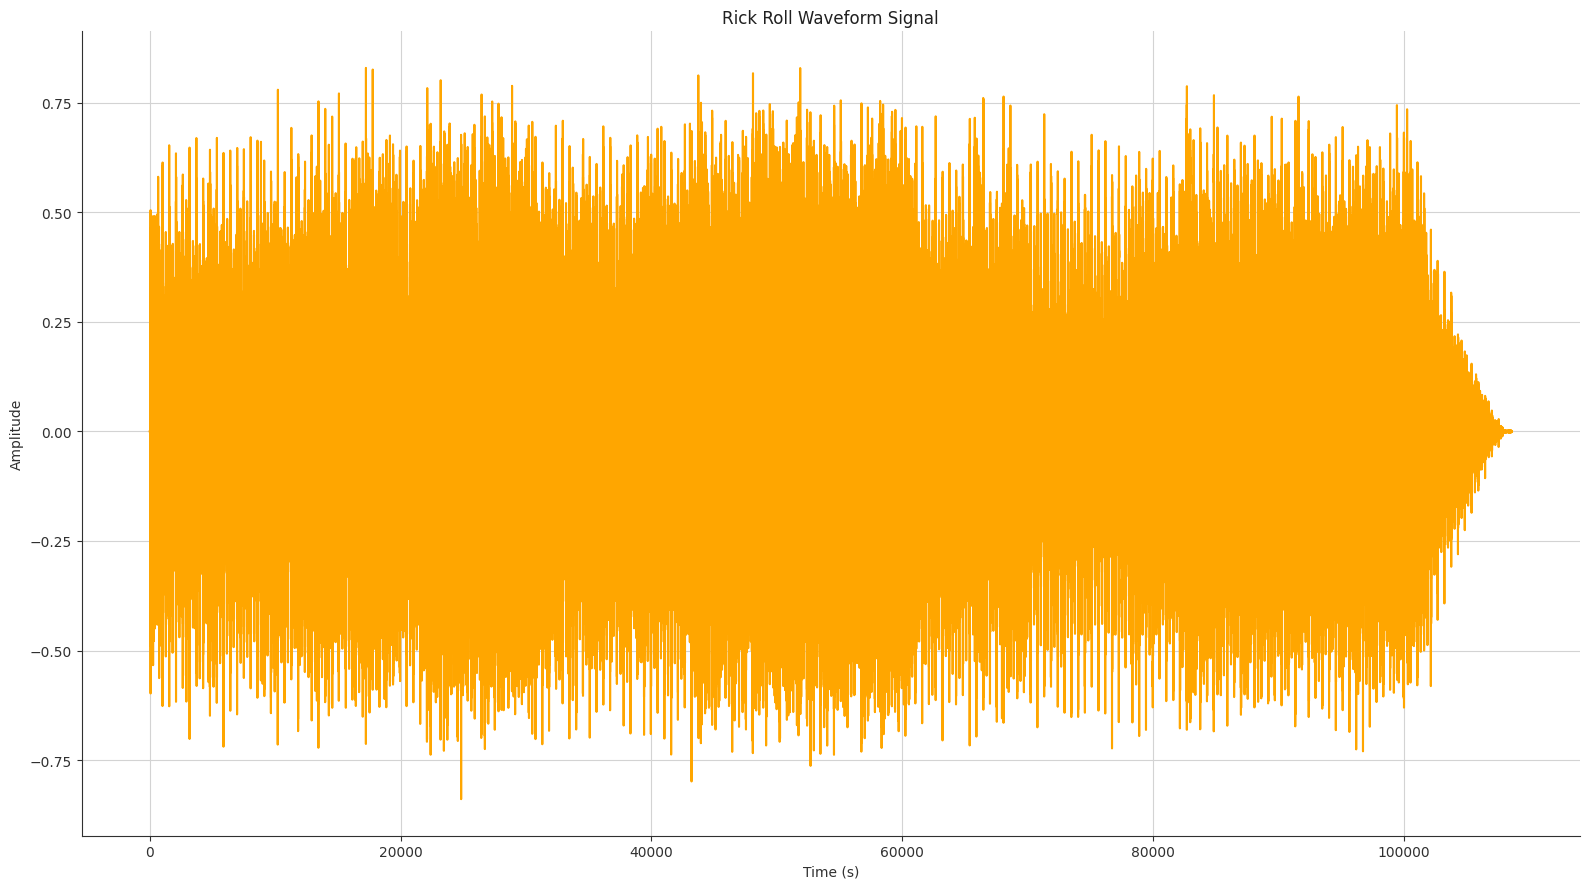

In [30]:
def load_audio_file(audio_path: str = "inputs/rick_roll.wav"):
    y, sr = librosa.load(audio_path, sr=None)
    t = librosa.times_like(y, sr=sr)
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    plt.plot(t, y)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Rick Roll Waveform Signal')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('outputs/images/rick_roll_waveform.png')
    plt.show()
    return y, sr, t

y, sr, t = load_audio_file()

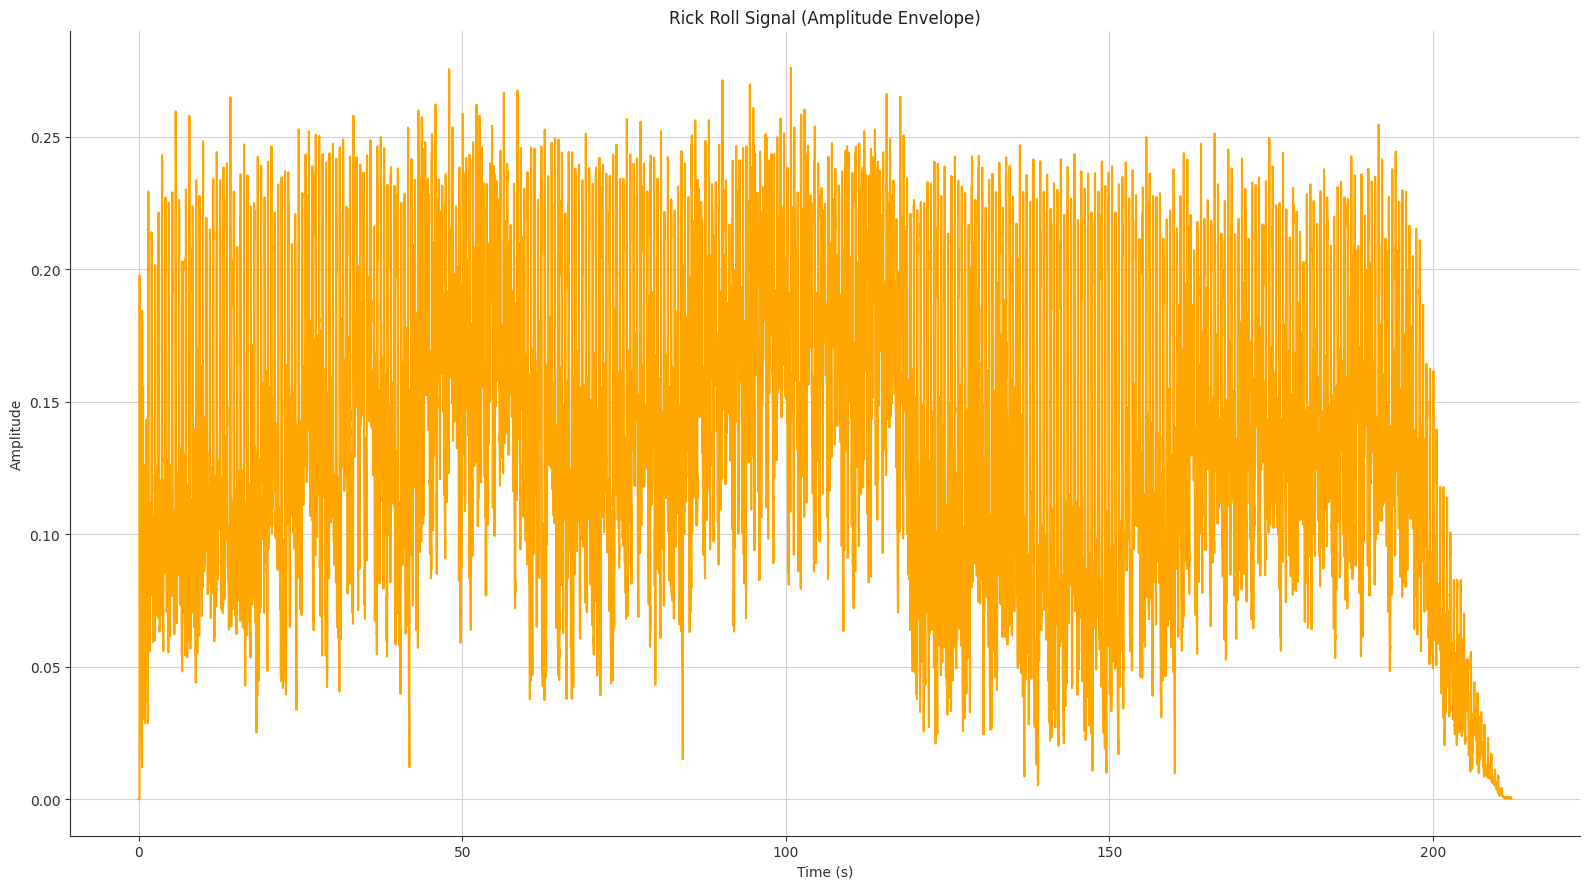

In [31]:
def get_amplitude_envelope(y, frame_size, hop_length):
    amplitude_envelope = np.abs(librosa.feature.rms(y=y, frame_length=frame_size, hop_length=hop_length)[0])
    t = librosa.times_like(amplitude_envelope, sr=sr, hop_length=hop_length)
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    plt.plot(t, amplitude_envelope)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Rick Roll Signal (Amplitude Envelope)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('outputs/images/rock_roll_amplitude_envelope.png')
    plt.show()
    return t, amplitude_envelope

frame_size = 1024
hop_length = 512
t, amplitude_envelope = get_amplitude_envelope(y, frame_size, hop_length)

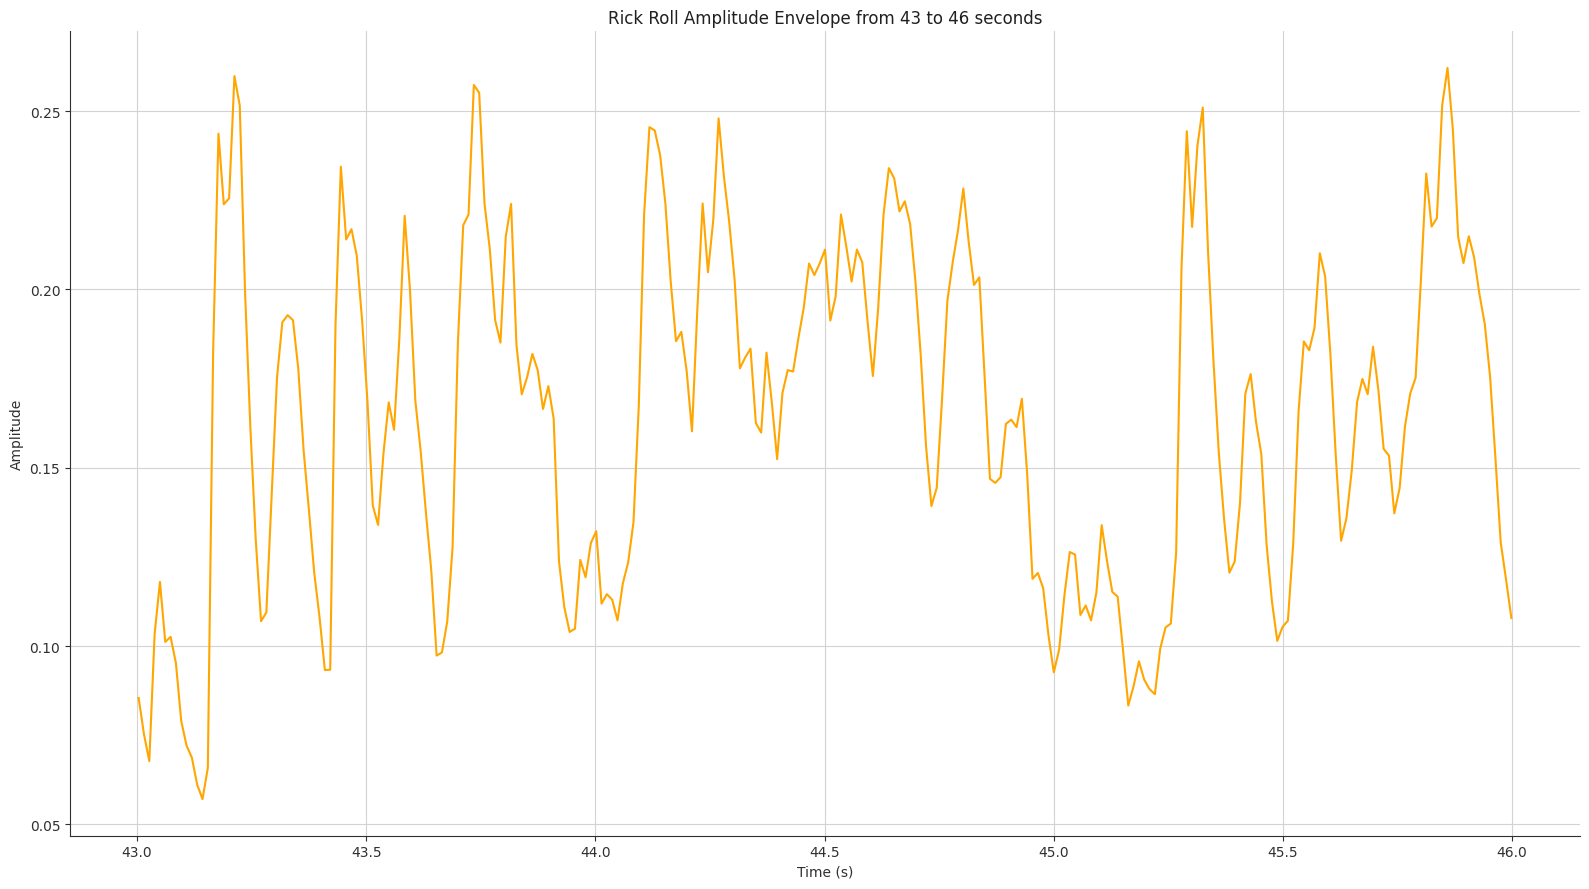

In [32]:
def crop_audio(amplitude_envelope, start_time_s, end_time_s):
    start_idx = np.searchsorted(t, start_time_s)
    end_idx = np.searchsorted(t, end_time_s)
    # Crop the audio signal and the amplitude envelope
    t_segment = t[start_idx:end_idx]
    amplitude_envelope_segment = amplitude_envelope[start_idx:end_idx]
    
    # Plot the amplitude envelope for the specific segment
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    plt.plot(t_segment, amplitude_envelope_segment)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f'Rick Roll Amplitude Envelope from {start_time_s} to {end_time_s} seconds')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('outputs/images/rock_roll_segment_amplitude_envelope.png')
    plt.show()
    return t_segment, amplitude_envelope_segment

t_segment, amplitude_envelope_segment = crop_audio(amplitude_envelope, start_time_s=43, end_time_s=46)

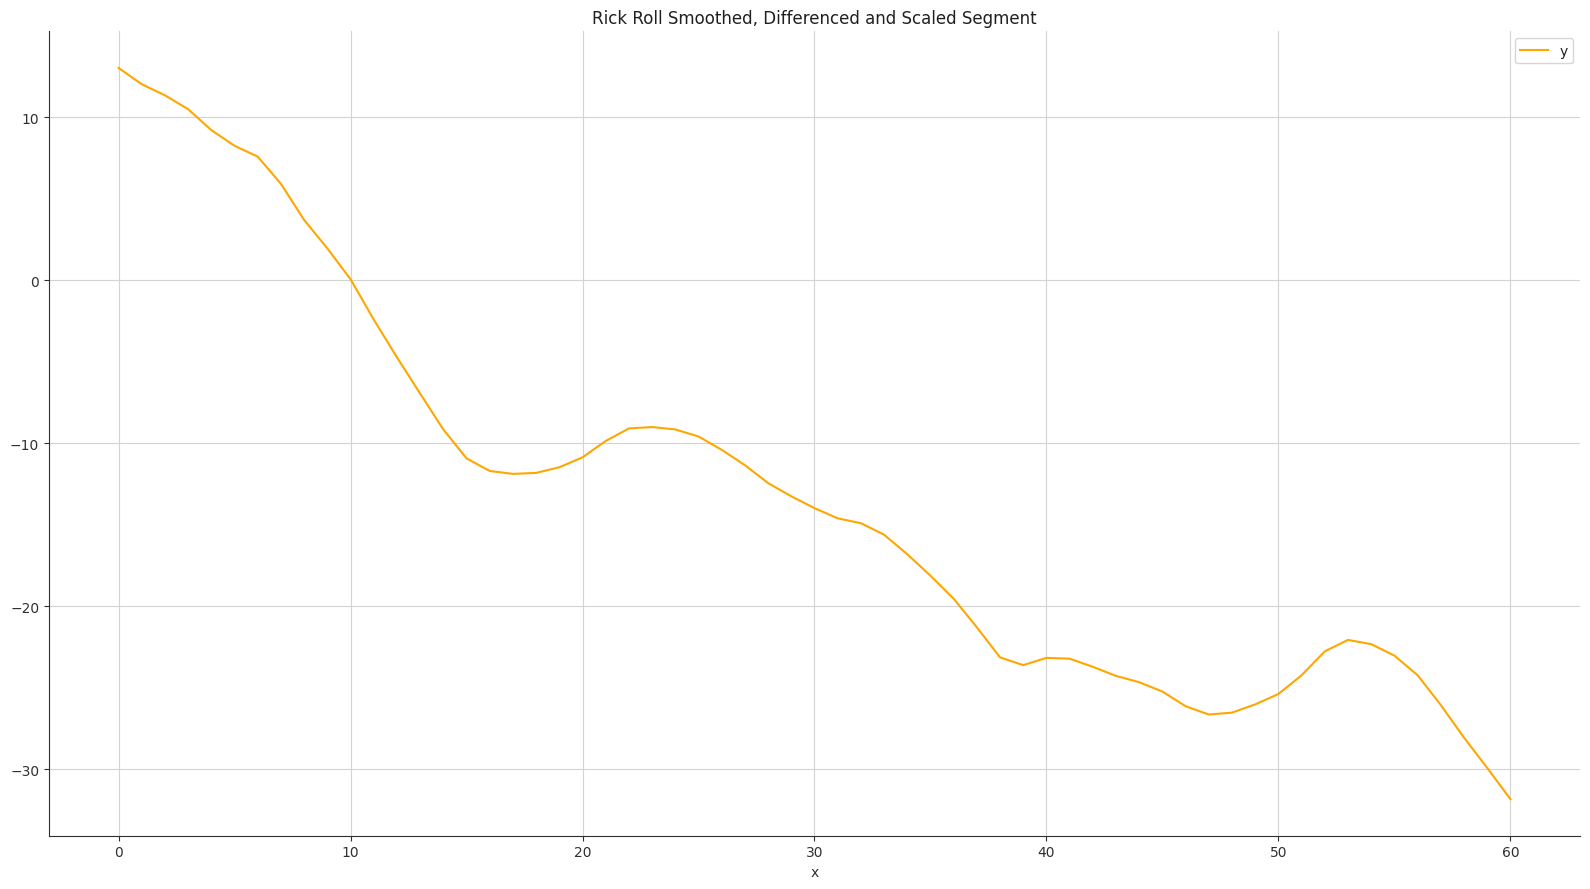

61


In [33]:
def process_and_smooth_data(inout_df: pd.DataFrame) -> pd.DataFrame:
    df = inout_df.copy(deep=True)
    # smoothing the time series with a rolling average
    df['y'] = df['y'].rolling(window=100).mean()
    df.dropna(inplace=True)
    # Move the time series to have a mean of 0
    df['y'] = df['y'] - df['y'].mean()
    # Differencing the time series and smoothing it
    df['y'] = df['y'].diff().bfill().rolling(window=100).mean()
    df.dropna(inplace=True)
    # set x equal to index instead of timeseries x
    df['x'] = df.reset_index(drop=True).index
    # Scale the time series
    df['y'] = df['y'] * 100000
    df.to_csv('inputs/rickroll_array.csv', index=False, header=False)
    return df

def plot_timeseries(df: pd.DataFrame) -> None:
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    df.plot(x='x', y='y', ax=ax)
    plt.title('Rick Roll Smoothed, Differenced and Scaled Segment')
    plt.tight_layout()
    plt.savefig('outputs/images/rock_roll_segment_transformed_amplitude_envelope.png')
    plt.show()

rock_roll_df = pd.DataFrame({'x': t_segment, 'y': amplitude_envelope_segment})
rock_roll_df = process_and_smooth_data(rock_roll_df)
plot_timeseries(rock_roll_df)